# STM Transit Delay Feature Engineering and Data Preprocessing

This notebook preprocesses data about STM trip updates and historical weather data.

## Data Description

`trip_id` unique identifier of a trip<br>
`route_id` bus or metro line<br>
`stop_id` stop number<br>
`stop_lat`stop latitude<br>
`stop_lon`stop longitude<br>
`stop_sequence` sequence of the stop, for ordering<br>
`wheelchair_boarding` indicates if the stop is accessible for people in wheelchair, 1 being true and 2 being false<br>
`realtime_arrival_time` actual arrival time, in milliseconds<br>
`scheduled_arrival_time` planned arrival time, in milliseconds<br>
`temperature` air temperature at 2 meters above ground, in Celsius<br>
`precipitation` total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters<br>
`windspeed` wind speed at 10 meters above ground, in km/h<br>
`weathercode` World Meteorological Organization (WMO) code<br>

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
import sys

In [2]:
# Import custom code
sys.path.insert(0, '..')
from scripts.custom_functions import LOCAL_TIMEZONE, WEATHER_CODES

In [3]:
# Load data
df = pd.read_csv('../data/stm_weather_merged.csv')

## Feature Engineering

In [4]:
# Convert real and scheduled timestamps
df['realtime_arrival_time'] = pd.to_datetime(df['realtime_arrival_time'], origin='unix', unit='ms', utc=True)
df['scheduled_arrival_time'] = pd.to_datetime(df['scheduled_arrival_time'], origin='unix', unit='ms', utc=True)

In [5]:
# Calculate delay in seconds (real - scheduled)
df['delay'] = (df['realtime_arrival_time'] - df['scheduled_arrival_time']).dt.total_seconds()

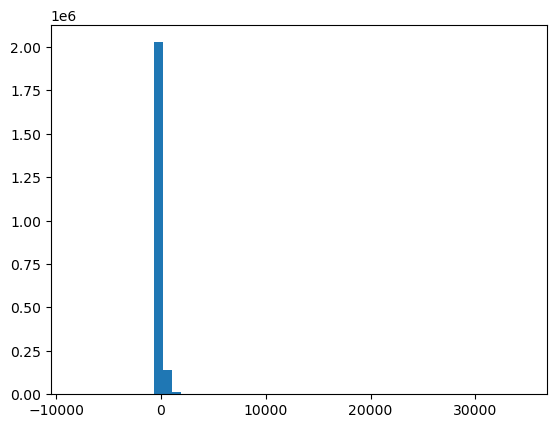

In [6]:
plt.hist(df['delay'], bins=50);

We can already see there are some massive outliers.

In [7]:
# Sort values by stop sequence
df = df.sort_values(by=['trip_id', 'route_id', 'stop_sequence'])

In [8]:
# Reset stop sequences (some stops are missing)
df['stop_sequence'] = df.groupby(['trip_id', 'route_id']).cumcount() + 1

In [9]:
# Calculate trip progress percentage
total_stops = df.groupby(['trip_id', 'route_id'])['stop_id'].transform('count')
df['trip_progress_pct'] = df['stop_sequence'] / total_stops

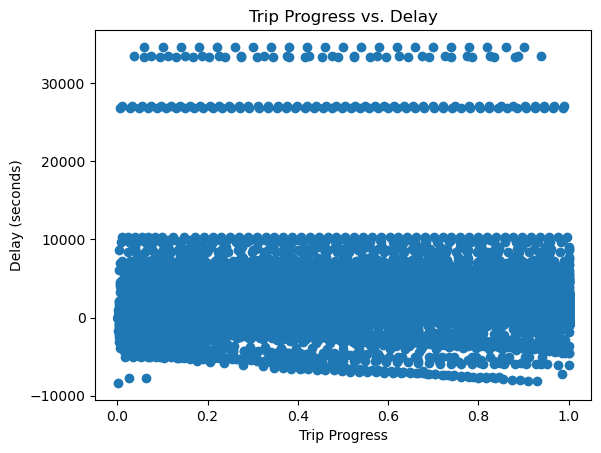

In [10]:
# Plot trip progress vs. delay
plt.scatter(x=df['trip_progress_pct'], y=df['delay'])
plt.title('Trip Progress vs. Delay')
plt.xlabel('Trip Progress')
plt.ylabel('Delay (seconds)')
plt.savefig('../images/delay_vs_trip_progress.png', bbox_inches='tight')
plt.show()

There are some big horizontal bands at very high delay (around 27,000–34,000 seconds = ~7.5 to 9 hours). Most normal delays are between -10000 and 10000 seconds, but it's still huge. The flat bands suggest that some vehichles are getting massively delayed and the delay remains stable throughout the trip or gets slightly worse. The huge delays (above 27k seconds) look suspicious. It might be data errors (maybe the bus broke down, there is missing data or it's a midnight wrap-around).

In [11]:
# Convert arrival times to local timezone
df['realtime_arrival_time'] = df['realtime_arrival_time'].dt.tz_convert(LOCAL_TIMEZONE)
df['scheduled_arrival_time'] = df['scheduled_arrival_time'].dt.tz_convert(LOCAL_TIMEZONE)
df.head()

,trip_id,route_id,stop_id,stop_lat,stop_lon,stop_sequence,wheelchair_boarding,realtime_arrival_time,scheduled_arrival_time,temperature,precipitation,windspeed,weathercode,delay,trip_progress_pct
1854061,283551791,51,50110,45.454203,-73.641481,1,True,2025-04-26 05:17:00-04:00,2025-04-26 05:17:00-04:00,8.5,0.7,10.5,53.0,0.0,0.02
1854062,283551791,51,53792,45.455601,-73.640855,2,True,2025-04-26 05:17:33-04:00,2025-04-26 05:17:33-04:00,8.5,0.7,10.5,53.0,0.0,0.04
1854063,283551791,51,50766,45.456750,-73.640602,3,True,2025-04-26 05:18:00-04:00,2025-04-26 05:18:00-04:00,8.5,0.7,10.5,53.0,0.0,0.06
1854064,283551791,51,50716,45.457449,-73.642413,4,True,2025-04-26 05:19:00-04:00,2025-04-26 05:19:00-04:00,8.5,0.7,10.5,53.0,0.0,0.08
1854065,283551791,51,50648,45.458560,-73.645283,5,True,2025-04-26 05:19:51-04:00,2025-04-26 05:19:51-04:00,8.5,0.7,10.5,53.0,0.0,0.10


In [12]:
# Convert datetime to day and hour
df['day'] = df['realtime_arrival_time'].dt.day_of_week
df['hour'] = df['realtime_arrival_time'].dt.hour

In [13]:
# Get average delay by stop, day and hour
stop_hour_avg_delay = df.groupby(['stop_id', 'day', 'hour'])['delay'].mean().reset_index()
stop_hour_avg_delay = stop_hour_avg_delay.rename(columns={'delay': 'historical_avg_delay'})
df = df.merge(stop_hour_avg_delay, on=['stop_id', 'hour'], how='left')
df.head()

,trip_id,route_id,stop_id,stop_lat,stop_lon,stop_sequence,wheelchair_boarding,realtime_arrival_time,scheduled_arrival_time,temperature,precipitation,windspeed,weathercode,delay,trip_progress_pct,day_x,hour,day_y,historical_avg_delay
0,283551791,51,50110,45.454203,-73.641481,1,True,2025-04-26 05:17:00-04:00,2025-04-26 05:17:00-04:00,8.5,0.7,10.5,53.0,0.0,0.02,5,5,2,0.000000
1,283551791,51,50110,45.454203,-73.641481,1,True,2025-04-26 05:17:00-04:00,2025-04-26 05:17:00-04:00,8.5,0.7,10.5,53.0,0.0,0.02,5,5,3,0.000000
2,283551791,51,50110,45.454203,-73.641481,1,True,2025-04-26 05:17:00-04:00,2025-04-26 05:17:00-04:00,8.5,0.7,10.5,53.0,0.0,0.02,5,5,4,0.000000
3,283551791,51,50110,45.454203,-73.641481,1,True,2025-04-26 05:17:00-04:00,2025-04-26 05:17:00-04:00,8.5,0.7,10.5,53.0,0.0,0.02,5,5,5,40.666667
4,283551791,51,53792,45.455601,-73.640855,2,True,2025-04-26 05:17:33-04:00,2025-04-26 05:17:33-04:00,8.5,0.7,10.5,53.0,0.0,0.04,5,5,2,0.000000


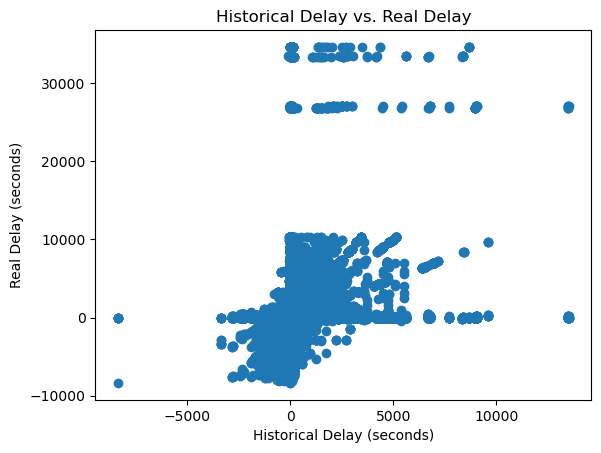

In [14]:
# Plot historical delay vs real delay
plt.scatter(x=df['historical_avg_delay'], y=df['delay'])
plt.title('Historical Delay vs. Real Delay')
plt.xlabel('Historical Delay (seconds)')
plt.ylabel('Real Delay (seconds)')
plt.savefig('../images/hist_vs_real_delay.png', bbox_inches='tight')
plt.show()

Most points are clustered tightly around the origin (0, 0), meaning a lot of stops are historically on-time and remain on-time. There is a visible positive correlation but it's not perfect. This suggests that historical averages are predictive. Also, external factors like weather, traffic and breakdowns can increase the real delay.

In [15]:
# Examine extreme outliers (above 27k seconds)
outlier_mask = df['delay'] > 27000
df[outlier_mask]

,trip_id,route_id,stop_id,stop_lat,stop_lon,stop_sequence,wheelchair_boarding,realtime_arrival_time,scheduled_arrival_time,temperature,precipitation,windspeed,weathercode,delay,trip_progress_pct,day_x,hour,day_y,historical_avg_delay
2471817,284778152,166,52195,45.495939,-73.579665,2,True,2025-04-24 07:10:23-04:00,2025-04-23 23:40:00-04:00,11.7,0.0,8.6,3.0,27023.0,0.010753,3,7,2,37.800000
2471818,284778152,166,52195,45.495939,-73.579665,2,True,2025-04-24 07:10:23-04:00,2025-04-23 23:40:00-04:00,11.7,0.0,8.6,3.0,27023.0,0.010753,3,7,3,4515.000000
2471819,284778152,166,52195,45.495939,-73.579665,2,True,2025-04-24 07:10:23-04:00,2025-04-23 23:40:00-04:00,11.7,0.0,8.6,3.0,27023.0,0.010753,3,7,4,11.000000
2471829,284778152,166,52113,45.496563,-73.582643,6,True,2025-04-24 07:11:23-04:00,2025-04-23 23:41:00-04:00,11.7,0.0,8.6,3.0,27023.0,0.032258,3,7,2,11.250000
2471830,284778152,166,52113,45.496563,-73.582643,6,True,2025-04-24 07:11:23-04:00,2025-04-23 23:41:00-04:00,11.7,0.0,8.6,3.0,27023.0,0.032258,3,7,3,2251.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782779,285283898,150,52149,45.489194,-73.580721,70,True,2025-04-25 09:18:38-04:00,2025-04-25 00:02:14-04:00,14.3,0.0,10.8,3.0,33384.0,0.833333,4,9,5,53.000000
5782789,285283898,150,52078,45.488258,-73.582891,74,True,2025-04-25 09:19:35-04:00,2025-04-25 00:03:11-04:00,14.3,0.0,10.8,3.0,33384.0,0.880952,4,9,2,171.500000
5782790,285283898,150,52078,45.488258,-73.582891,74,True,2025-04-25 09:19:35-04:00,2025-04-25 00:03:11-04:00,14.3,0.0,10.8,3.0,33384.0,0.880952,4,9,3,64.000000
5782791,285283898,150,52078,45.488258,-73.582891,74,True,2025-04-25 09:19:35-04:00,2025-04-25 00:03:11-04:00,14.3,0.0,10.8,3.0,33384.0,0.880952,4,9,4,6695.400000


## Data Preprocessing

### Flag outliers

In [16]:
# Filter outliers by standard deviation
mean_delay = df['delay'].mean()
std_delay = df['delay'].std()

not_outlier_mask = (df['delay'] >= mean_delay - 3 * std_delay) & (df['delay'] <= mean_delay + 3 * std_delay)

In [17]:
# Add a flag to indicate the model it's dealing with unusual delays
df['delay_was_clipped'] = False
df.loc[~not_outlier_mask, 'delay_was_clipped'] = True

In [18]:
# Clip delays
df.loc[(df['delay'] < mean_delay - 3 * std_delay), 'delay'] = mean_delay - 3 * std_delay
df.loc[(df['delay'] > mean_delay + 3 * std_delay), 'delay'] = mean_delay + 3 * std_delay

In [19]:
df['delay_was_clipped'].value_counts()

delay_was_clipped
False    7349242
True       51692
Name: count, dtype: int64

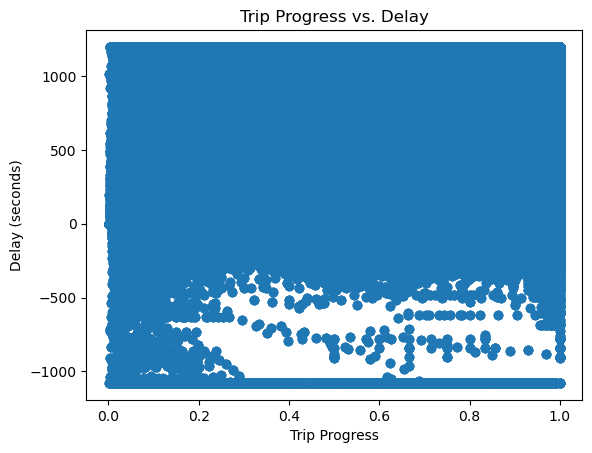

In [20]:
# Plot trip progress vs. delay after clipping
plt.scatter(x=df['trip_progress_pct'], y=df['delay'])
plt.title('Trip Progress vs. Delay')
plt.xlabel('Trip Progress')
plt.ylabel('Delay (seconds)')
plt.savefig('../images/delay_vs_trip_progress2.png', bbox_inches='tight')
plt.show()

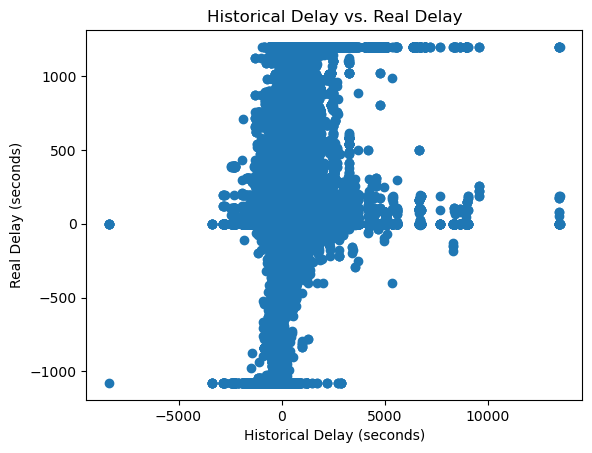

In [21]:
# Plot historical delay vs real delay after clipping
plt.scatter(x=df['historical_avg_delay'], y=df['delay'])
plt.title('Historical Delay vs. Real Delay')
plt.xlabel('Historical Delay (seconds)')
plt.ylabel('Real Delay (seconds)')
plt.savefig('../images/hist_vs_real_delay2.png', bbox_inches='tight')
plt.show()

### Encode Datetime

In [22]:
# Get day and hour from time
df['day'] = df['realtime_arrival_time'].dt.day_of_week
df['hour'] = df['realtime_arrival_time'].dt.hour
df['sch_day'] = df['scheduled_arrival_time'].dt.day_of_week
df['sch_hour'] = df['scheduled_arrival_time'].dt.hour

In [23]:
# Use Cyclical Encoding for day and hour, as it's more suitable for time-related features
# And the model can "understand" the wrap-around
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 7)

df['sch_day_sin'] = np.sin(2 * np.pi * df['sch_day'] / 7)
df['sch_day_cos'] = np.cos(2 * np.pi * df['sch_day'] / 7)

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['sch_hour_sin'] = np.sin(2 * np.pi * df['sch_hour'] / 24)
df['sch_hour_cos'] = np.cos(2 * np.pi * df['sch_hour'] / 24)

In [24]:
# Add boolean value is_weekend
weekend_mask = df['day'].isin([5, 6])
df['is_weekend'] = np.where(weekend_mask, 1, 0)

In [25]:
# Add boolean value is_peak_hour (weekdays from 7-9am or 4-6pm)
peak_hour_mask = (weekend_mask == False) & (df['hour'].isin([7, 8, 9, 16, 17, 18]))
df['is_peak_hour'] = np.where(peak_hour_mask, 1, 0)

### Convert boolean columns to integer

In [26]:
df['wheelchair_boarding'] = df['wheelchair_boarding'].astype('int64')

### Use Label Encoding for route_id and stop_id

In [27]:
le_route = LabelEncoder()
df['route_id'] = le_route.fit_transform(df['route_id'])

In [28]:
le_stop = LabelEncoder()
df['stop_id'] = le_stop.fit_transform(df['stop_id'])

### Convert weathercode Into Categories

In [29]:
# Create weather code mapping
weathercodes = df['weathercode'].sort_values().unique()
condition_list = []
label_list = []

for code in weathercodes:
  condition_list.append(df['weathercode'] == code)
  label_list.append(WEATHER_CODES[code])

In [37]:
# Create categories
df['weather'] = np.select(condition_list, label_list, default='Unknown')

In [38]:
# Collapsing categories to 6 max
df['weather'].value_counts()

weather
Overcast            3499574
Clear sky           2141065
Partly cloudy        656322
Light drizzle        362309
Slight rain          302743
Moderate drizzle     226638
Mainly clear         127524
Dense drizzle         84759
Name: count, dtype: int64

In [39]:
df['weather'] = np.where(df['weather'].isin(['Light drizzle', 'Moderate drizzle', 'Dense drizzle']), 'Drizzle', df['weather'])
df['weather'].value_counts()

weather
Overcast         3499574
Clear sky        2141065
Drizzle           673706
Partly cloudy     656322
Slight rain       302743
Mainly clear      127524
Name: count, dtype: int64

In [40]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['weather'], drop_first=True, dtype='int64', prefix='weather')
df = df.drop(['weathercode', 'weather'], axis=1).join(one_hot)

KeyError: "['weathercode'] not found in axis"

### Reduce station coordinates to one feature (PCA)

In [43]:
stop_coords = df[['stop_lat', 'stop_lon']]
stop_coords

,stop_lat,stop_lon
0,45.454203,-73.641481
1,45.454203,-73.641481
2,45.454203,-73.641481
3,45.454203,-73.641481
4,45.455601,-73.640855
...,...,...
7400929,45.499992,-73.565764
7400930,45.469756,-73.536156
7400931,45.469756,-73.536156
7400932,45.469756,-73.536156


In [44]:
# Scale the coordinates because PCA works best with normalized features
scaler_coord = StandardScaler()
coords_scaled = scaler_coord.fit_transform(stop_coords)
coords_scaled

array([[-1.147633  , -0.09451868],
       [-1.147633  , -0.09451868],
       [-1.147633  , -0.09451868],
       ...,
       [-0.90394681,  1.09411866],
       [-0.90394681,  1.09411866],
       [-0.90394681,  1.09411866]])

In [45]:
# Apply PCA
pca = PCA(n_components=1)
pca_coords = pca.fit_transform(coords_scaled)
df['pca_coords'] = pca_coords

## Export Data

In [46]:
df.columns

Index(['trip_id', 'route_id', 'stop_id', 'stop_lat', 'stop_lon',
       'stop_sequence', 'wheelchair_boarding', 'realtime_arrival_time',
       'scheduled_arrival_time', 'temperature', 'precipitation', 'windspeed',
       'delay', 'trip_progress_pct', 'day_x', 'hour', 'day_y',
       'historical_avg_delay', 'delay_was_clipped', 'day', 'sch_day',
       'sch_hour', 'day_sin', 'day_cos', 'sch_day_sin', 'sch_day_cos',
       'hour_sin', 'hour_cos', 'sch_hour_sin', 'sch_hour_cos', 'is_weekend',
       'is_peak_hour', 'weather_Drizzle', 'weather_Mainly clear',
       'weather_Overcast', 'weather_Partly cloudy', 'weather_Slight rain',
       'weather', 'pca_coords'],
      dtype='object')

In [48]:
# Keep encoded columns and reorder them
df = df[[ 'route_id', 'stop_id', 'pca_coords', 'stop_sequence', 'trip_progress_pct',
  		'wheelchair_boarding', 'day_sin', 'day_cos', 'sch_day_sin', 'sch_day_cos', 'hour_sin', 'hour_cos', 
  		'sch_hour_sin', 'sch_hour_cos', 'is_weekend', 'is_peak_hour', 'historical_avg_delay', 'delay_was_clipped',
  		'temperature', 'precipitation', 'windspeed', 'weather_Drizzle', 'weather_Mainly clear',
       'weather_Overcast', 'weather_Partly cloudy', 'weather_Slight rain',
  		'weather_Partly cloudy', 'weather_Slight rain', 'delay']]

In [49]:
# Export encoders
encoders = {
  'le_route': le_route,
  'le_stop': le_stop
}
with open('../models/label_encoders.pickle', 'wb') as handle:
	pickle.dump(encoders, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [50]:
# Export scaler
with open('../models/coord_scaler.pickle', 'wb') as handle:
	pickle.dump(scaler_coord, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [51]:
# Export coordinates PCA
with open('../models/coord_pca.pickle', 'wb') as handle:
	pickle.dump(pca_coords, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7400934 entries, 0 to 7400933
Data columns (total 29 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   route_id               int64  
 1   stop_id                int64  
 2   pca_coords             float64
 3   stop_sequence          int64  
 4   trip_progress_pct      float64
 5   wheelchair_boarding    int64  
 6   day_sin                float64
 7   day_cos                float64
 8   sch_day_sin            float64
 9   sch_day_cos            float64
 10  hour_sin               float64
 11  hour_cos               float64
 12  sch_hour_sin           float64
 13  sch_hour_cos           float64
 14  is_weekend             int64  
 15  is_peak_hour           int64  
 16  historical_avg_delay   float64
 17  delay_was_clipped      bool   
 18  temperature            float64
 19  precipitation          float64
 20  windspeed              float64
 21  weather_Drizzle        int64  
 22  weather_Mainly cle

In [ ]:
# Export dataframe
df.to_csv('../data/preprocessed.csv', index=False)

## End